In [1]:
from google.colab import drive
drive.mount('/ML_Project/')
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /ML_Project/
Mounted at /content/drive


In [2]:
import pandas as pd

ratings_df=pd.read_csv('/content/drive/My Drive/ML_Project/Recommendation/ratings_Electronics.csv')
ratings_df.columns=['userID','productID','rating','timeStamp']
ratings_df.head()

,userID,productID,rating,timeStamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
1,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
2,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
3,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09
4,A1QGNMC6O1VW39,0511189877,5.0,1.397434e+09


In [3]:
ratings_df.rating.unique()

# Ratings are in the range starting from 1 to 5
# There is no possibility of outliers in this case
# Since other variables are unique ID's, we cannot check for outliers

array([ 5.,  1.,  3.,  2.,  4., nan])

In [0]:
# FILTER OUT USERS WITH MORE THAN OR EQUAL TO 50

count=ratings_df['userID'].value_counts()
ratings_df=ratings_df[ratings_df['userID'].isin(count[count>=50].index)]

# DROPPING TIMESTAMP VARIABLE
ratings_df.drop(['timeStamp'],axis=1,inplace=True)

In [5]:
ratings_df.rating.unique()

array([5., 3., 1., 4., 2.])

In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121124 entries, 93 to 7773008
Data columns (total 3 columns):
userID       121124 non-null object
productID    121124 non-null object
rating       121124 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.7+ MB


In [8]:
ratings_df.describe(include='all').T

# 50% of the user ratings are 5 which suggests that users sacrifice their time to give rating to good movies mostly

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userID,121124,1495,A5JLAU2ARJ0BO,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productID,121124,46865,B0088CJT4U,203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,121124,NaN,NaN,NaN,4.25893,1.06511,1,4,5,5,5


In [0]:
# SPLIT DATA INTO TRAIN AND TEST

from sklearn.model_selection import train_test_split

train_DF, test_DF =train_test_split(ratings_df,test_size=0.30,random_state=1)

In [0]:
# FUNCTION TO GET THE MOST POPULAR PRODUCTS
def mostPopular(df):
  mean_count_df=pd.DataFrame(df.groupby('productID')['rating'].mean())
  mean_count_df['counts']=df.groupby('productID')['rating'].count()
  mean_count_df['score']=mean_count_df['rating']*mean_count_df['counts']
  mean_count_df=mean_count_df.sort_values(['score'],ascending=False).head()
  return mean_count_df

In [16]:
# MOST POPULAR PRODUCTS IN THE TRAIN DATA
mostPopular(train_DF).head()

,rating,counts,score
productID,,,
B003ES5ZUU,4.874074,135,658.0
B0088CJT4U,4.242857,140,594.0
B007WTAJTO,4.720721,111,524.0
B000N99BBC,4.761468,109,519.0
B00829TIEK,4.471698,106,474.0


In [17]:
# MOST POPULAR PRODUCTS IN THE TEST DATA

mostPopular(test_DF).head()

# Since 'B003ES5ZUU','B0088CJT4U' and 'B007WTAJTO' have topped in both train and test sets, those products should be the most popular in the given data

,rating,counts,score
productID,,,
B0088CJT4U,4.158730,63,262.0
B000N99BBC,4.788462,52,249.0
B007WTAJTO,4.640000,50,232.0
B003ES5ZUU,4.826087,46,222.0
B008DWCRQW,4.061224,49,199.0


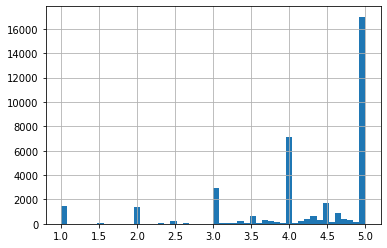

In [0]:
mean_count_df['rating'].hist(bins=50)

# Most of the products are given 5 as rating

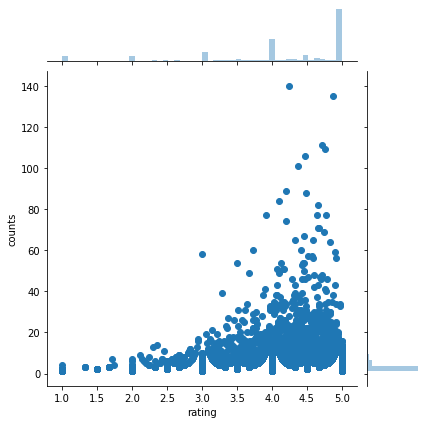

In [0]:
import seaborn as sns
sns.jointplot(x='rating', y='counts', data=mean_count_df)

In [18]:
# INSTALLING SURPRISE PACKAGE

!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 2.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678232 sha256=8fdd3ae67e14d7a8ff7a155dc55f9ad546fc294ccc23381b18a23cf5d9ada6c9
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [20]:
# TRAINING THE SVD MODEL

from surprise import SVD
from surprise import Dataset
from surprise import Reader
reader = Reader(rating_scale=(1, 5))

# considering the top 50000 records to accustom the system capability
svd_df=Dataset.load_from_df(train_DF.head(50000),reader=reader)
svd_model=SVD()
trainSVD_df=svd_df.build_full_trainset()
svd_model.fit(trainSVD_df)

In [21]:
# GET THE TEST DATA FROM THE TRAIN DATA AND GET THE PREDCTIONS

testSVD_df=trainSVD_df.build_anti_testset()
predictions=svd_model.test(testSVD_df)
predictions[38]

Prediction(uid='A1HBI9BBQIG1NH', iid='B000ELE4Q6', r_ui=4.25712, est=3.912665898920191, details={'was_impossible': False})

In [0]:
# DEFINE A METHOD THAT WILL GET THE TOP K RECOMMENDATIONS FOR EASH USER

from collections import defaultdict
def top_k(predictions,k):
      top_k=defaultdict(list) 
      # creating a dictionary with userID as key and (productid,estimated rating) as values
      for uid,iid,_,est,_ in predictions:
        top_k[uid].append((iid,est))

      # Sorting the ratings for each user in the dictionary
      for userID,rating_est in top_k.items():
        rating_est.sort(key=(lambda x : x[1]),reverse=True)
        top_k[userID]=rating_est[:k]
      
      return top_k

In [11]:
# TOP 5 RECOMMENDATIONS FOR THE USER 'A1HBI9BBQIG1NH'
recommends=top_k(predictions,5)
recommends['A1HBI9BBQIG1NH']

[('B002V8C3W2', 4.616267764558126),
 ('B003NR57BY', 4.609462315041144),
 ('B002V88HFE', 4.60217523652157),
 ('B0015AARJI', 4.588574874693931),
 ('B00429N18S', 4.563822191187141)]

In [24]:
# RMSE OF THE PREDICTIONS

from surprise import accuracy

accuracy.rmse(predictions)

# 0.39 RMSE is a good model (lesser rmse value better is the model)

RMSE: 0.3918


0.3918243398227639

In [0]:
# OBSERVATIONS :
# 1) It can be observed from the data that more than half of the product ratings are more than 4.
#    From which we can infer that user mostly rate the product when they are very satified with the product.
# 2) Products - 'B003ES5ZUU','B0088CJT4U' and 'B007WTAJTO' should be the most popular products in the given data as per user ratings.
# 3) The top recommended products for each user are having an estimated rating of around 4.5 which implies that no product is strongly
#    recommended. This might be due to lesser number of ratings given by each user on different products.
# 4) A RMSE of 0.39 implies that the model has performed well as a lesser RMSE corresponds to lesser error.